# SDTW on Trainging with Unaligned Dataset
# Setting up Environment

```
$ python -m venv sdtw
$ source sdtw/bin/activate # for linux
$ ./sdtw/Scripts/activate # for windows
$ python.exe -m pip install --upgrade pip # upgrade pip
$ pip install -r requirements.txt
```

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import IPython.core.display as ipd
import pandas as pd
import os
import torch
import libfmp.c5

from lib.nn_losses.soft_dtw_cuda import SoftDTW
from lib.nn_models.nn_dchord import dchord_pipeline
from lib.helpers.soft_align import soft_align


# Initalize dChord Network

In [78]:
# Pipeline config

compression_params = {'gamma_init': 1.0,
                      'trainable': True}

feature_norm_params = {'num_features': 12,
                       'norm': '2', 
                       'threshold': 1e-4}

chord_template_params = {'shared_weights': True, 
                         'initialize_parameters': True, 
                         'normalize_weights': False}

softmax_params = {'tau': 1, 
                  'trainable': False}

In [79]:
model = dchord_pipeline(compression_params=compression_params, 
                        feature_norm_params=feature_norm_params, chord_template_params=chord_template_params,
                        softmax_params=softmax_params)

In [80]:
import torchinfo

torchinfo.summary(model, input_size=(1, 1, 40, 12), col_names=["input_size", "output_size", "num_params", "trainable"], col_width=20)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
dchord_pipeline                          [1, 1, 40, 12]       [1, 1, 40, 24]       --                   Partial
├─log_compression: 1-1                   [1, 1, 40, 12]       [1, 1, 40, 12]       1                    True
├─feature_normalization: 1-2             [1, 1, 40, 12]       [1, 1, 40, 12]       --                   --
├─dchord_templates: 1-3                  [1, 1, 40, 12]       [1, 1, 40, 24]       --                   True
│    └─Conv2d: 2-1                       [1, 1, 40, 23]       [1, 2, 40, 12]       24                   True
├─softmax_temperature: 1-4               [1, 1, 40, 24]       [1, 1, 40, 24]       (1)                  False
Total params: 26
Trainable params: 25
Non-trainable params: 1
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.00
Estimated Total Size (MB): 0.02

In [81]:
normalize = False
sharp = False
sharp_weight_by_avg_alignment_sum = False


criterion = SoftDTW(use_cuda=False, gamma=1.0, dist_func=None, normalize=normalize)

# Preparing Data for Training

In [82]:
nonchord = False
data_basedir = './res/data'

In [83]:
song_dict = {}

song_dict[0] = ['LetItB', 'r',
                os.path.join(data_basedir, 'FMP_C5_F01_Beatles_LetItBe-mm1-4_Original.wav'),
                os.path.join(data_basedir, 'FMP_C5_F01_Beatles_LetItBe-mm1-4_Original_Chords_simplified.csv')]
song_dict[1] = ['HereCo', 'b',
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_HereComesTheSun_Beatles_1969-AbbeyRoad-07.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_HereComesTheSun_Beatles_1969-AbbeyRoad-07_Chords_simplified.csv')]
song_dict[2] = ['ObLaDi', 'c',
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_ObLaDiObLaDa_Beatles_1968-TheBeatlesTheWhiteAlbumDisc1-04.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_ObLaDiObLaDa_Beatles_1968-TheBeatlesTheWhiteAlbumDisc1-04_Chords_simplified.csv')]
song_dict[3] = ['PennyL', 'g',
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_PennyLane_Beatles_1967-MagicalMysteryTour-09.wav'),
                os.path.join(data_basedir, 'FMP_C5_Audio_Beatles_PennyLane_Beatles_1967-MagicalMysteryTour-09_Chords_simplified.csv')]

In [358]:
def compute_X_dict(song_selected, version='STFT', details=True, nonchord=False):
    X_dict = {}
    Fs_X_dict = {}
    ann_dict = {}
    x_dur_dict = {}
    chord_labels = libfmp.c5.get_chord_labels(ext_minor='m', nonchord=nonchord)
    for s in song_selected:
        if details is True:
            print('Processing: ', song_dict[s][0])
        fn_wav = song_dict[s][2]
        fn_ann = song_dict[s][3]
#         N = 2048
#         H = 1024
        N = 4096
        H = 2048
        if version == 'STFT':
            X, Fs_X, x, Fs, x_dur = \
                libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')            # no log compression
        if version == 'CQT':
            X, Fs_X, x, Fs, x_dur = \
                libfmp.c5.compute_chromagram_from_filename(fn_wav, H=H, version='CQT')                  # no log compression
        if version == 'IIR':
            X, Fs_X, x, Fs, x_dur = \
                libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=10, version='IIR')             # no log compression
            
        X_dict[s] = X
        Fs_X_dict[s] = Fs_X
        x_dur_dict[s] = x_dur
        N_X = X.shape[1]
        ann_dict[s] = libfmp.c5.convert_chord_ann_matrix(fn_ann, chord_labels, Fs=Fs_X, N=N_X, last=False)
    return X_dict, Fs_X_dict, ann_dict, x_dur_dict, chord_labels
    
song_selected = [0, 1, 2, 3]
#song_selected = [0]
print('===== Computation of STFT-based chromagrams =====')
X_dict_STFT, Fs_X_dict_STFT, ann_dict_STFT, x_dur_dict, chord_labels = compute_X_dict(song_selected, version='STFT', nonchord=nonchord)

===== Computation of STFT-based chromagrams =====
Processing:  LetItB
Processing:  HereCo
Processing:  ObLaDi
Processing:  PennyL


## Create Dataset + Dataloader

In [433]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, inputs, targets, target_length, dataset_params):
        self.inputs = inputs                                # Channels x Time x Chromas
        self.targets = targets                              # Time x Chords
        self.target_length = target_length                  # Length of each target sequence
        self.dataset_params = dataset_params                # Parameters for the dataset (e.g., context, stride)
    def __len__(self):
        return self.inputs.size()[0]
    
    def __getitem__(self, idx):
        X = self.inputs.type(torch.FloatTensor)
        y = self.targets.type(torch.FloatTensor)
        y_length = self.target_length.type(torch.FloatTensor)
        return X, y, y_length

In [434]:
def colldate_fn(batch):
    inputs = torch.stack([item[0] for item in batch], dim=0)  # Stack inputs along a new dimension
    targets = torch.cat([item[1] for item in batch], dim=0)  # Stack targets along a new dimension
    target_length = torch.stack([item[2] for item in batch], dim=0)  # Stack target lengths along a new dimension
    return inputs, targets, target_length

In [435]:
# Not used, kept for reference
class dataset_context(torch.utils.data.Dataset):
    def __init__(self, inputs, targets, params):
        self.inputs = inputs                                # Channels x Time x Chromas
        self.targets = targets                              # Time x Chords
        self.context = params['context']
        self.stride = params['stride']
        
    def __len__(self):
        return (self.inputs.size()[1] - self.context) // self.stride
    
    def __getitem__(self, index):
        index *= self.stride
        half_context = self.context // 2
        index += half_context
        X = self.inputs[:, (index - half_context):(index + half_context + 1), :].type(torch.FloatTensor)
        y = torch.unsqueeze(torch.unsqueeze(self.targets[index, :], 0), 1).type(torch.FloatTensor)
        return X, y

In [ ]:
def create_dataset(data_dict, ann_dict, song_dict, song_indices, dataset_params, dataset_description='train', mode='soft', type='sdtw'):
    all_datasets = []
    segment_length = dataset_params['segment_length']

    assert mode in ['full', 'soft'], "Mode must be either 'full' or 'soft' for dataset creation."
    assert type in ['sdtw', 'ctc'], "Type must be either 'sdtw' or 'ctc' for dataset creation."

    # Extract voiced frame annotations
    for s in song_indices:
        targets = ann_dict[s][0]
        voiced_frames = np.any(targets !=0, axis=0)
        print(voiced_frames.shape)
        if voiced_frames.sum() == 0:
            print(f'Warning: No voiced frames found for song {song_dict[s][0]}. Skipping this song.')
            continue
    
        s_idx = np.argmax(voiced_frames)
        e_idx = len(voiced_frames) - np.argmax(voiced_frames[::-1])
        targets_trimmed = targets[:, s_idx:e_idx]
        
        if type == 'ctc':
            # CTC get a sequence of chord labels
            label_seq = np.argmax(targets_trimmed, axis=0)
        elif type == 'sdtw':
            # SDTW get a matrix of one-hot encoded chord labels
            label_seq = targets_trimmed
        
        else:
            raise ValueError("Type must be either 'sdtw' or 'ctc'.")

        inputs = data_dict[s].T
        inputs_trimmed = inputs[s_idx:e_idx, :]
        T_total = inputs_trimmed.shape[0]
        num_segments = T_total // segment_length

        for i in range(num_segments):
            start_idx = i * segment_length
            end_idx = start_idx + segment_length
            
            if end_idx > T_total:
                break
            input_seg = inputs_trimmed[start_idx:end_idx, :]
            label_seg = label_seq[start_idx:end_idx]

            if mode == 'soft':
                target_seg = [ label_seg[0] ]
                for idx in range(1, len(label_seg)):
                    if label_seg[idx] != label_seg[idx-1]:
                        target_seg.append(label_seg[idx])

                target_seg = torch.tensor(target_seg, dtype=torch.float32)
                target_seg_len = torch.tensor([len(target_seg)], dtype=torch.int64)
                inputs_tensor = torch.unsqueeze(torch.tensor(input_seg, dtype=torch.float32), 0)

            elif mode == 'full':
                target_seg = torch.tensor(label_seg, dtype=torch.float32)
                target_seg_len = torch.tensor([len(target_seg)], dtype=torch.int64)
                inputs_tensor = torch.unsqueeze(torch.tensor(input_seg, dtype=torch.float32), 0)

            curr_dataset = dataset(inputs_tensor, target_seg, target_seg_len, dataset_params)
            all_datasets.append(curr_dataset)

        print(f'- {song_dict[s][0]} added to {dataset_description} set. Segments: {num_segments}')
        
    full_dataset = torch.utils.data.ConcatDataset(all_datasets)
    print(f'Total segments created for {dataset_description} dataset: {len(full_dataset)}')
    return full_dataset


In [484]:
train_set_indices = [1, 2]
train_set_params = {'segment_length': 40}

train_set = create_dataset(data_dict=X_dict_STFT, 
                           ann_dict=ann_dict_STFT, 
                           song_dict=song_dict, 
                           song_indices=train_set_indices, 
                           dataset_params=train_set_params, 
                           dataset_description='train',
                           mode='soft')

print('\n')

val_set_indices = [3]
val_set_params = {'segment_length': 40}

val_set = create_dataset(data_dict=X_dict_STFT, 
                         ann_dict=ann_dict_STFT, 
                         song_dict=song_dict, 
                         song_indices=val_set_indices, 
                         dataset_params=val_set_params, 
                         dataset_description='val',
                         mode='full')

[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
False
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0

/tmp/ipykernel_10027/4250349967.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_seg = torch.tensor(target_seg, dtype=torch.float32)


In [452]:
train_loader_params = {'batch_size': 1, 'shuffle': True, 'num_workers': 0, 'collate_fn': colldate_fn}
train_loader = torch.utils.data.DataLoader(train_set, **train_loader_params)
print(f'Training data loader contains {len(train_loader)} mini batches.')

val_loader_params = {'batch_size': 1, 'shuffle': False, 'num_workers': 0, 'collate_fn': colldate_fn}
val_loader = torch.utils.data.DataLoader(val_set, **val_loader_params)
print(f'Validation data loader contains {len(val_loader)} mini batches.')

Training data loader contains 99 mini batches.
Validation data loader contains 47 mini batches.


# Train Pipeline

## Specify which parameters to optimize

In [453]:
print('Trainable parameters:\n')

trainable_parameters = []
for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_parameters.append(name)
        print(f"'{name}'") 

Trainable parameters:

'log_compression.log_gamma'
'chord_template_params.filter.weight'


Optimization mode $\in \{0, 1, 2 \}$:  
- 0: optimize all trainable parameters 
- 1: optimize **all** trainable parameters **except** the ones specified in `frozen_parameters`
- 2: optimize **only** the parameters specified in `trained_parameters`

(`frozen_parameters` and `trained_parameters` must be lists of strings and a subset of the trainable parameters shown above)

For no optimization at all: set training epochs to zero.

In [454]:
optimization_mode = 0

if optimization_mode == 1:
    frozen_parameters = []           

if optimization_mode == 2:
    trained_parameters = []

In [455]:
if optimization_mode == 0:
    parameters_to_optimize = model.parameters()
    
elif optimization_mode == 1:
    parameters_to_optimize = []

    for name, param in model.named_parameters():
        if not name in frozen_parameters:
            parameters_to_optimize.append(param)
            
elif optimization_mode == 2:
    parameters_to_optimize = []

    for name, param in model.named_parameters():
        if name in trained_parameters:
            parameters_to_optimize.append(param)

### Set Optimizer, Training Parameters and Loss

In [456]:
optim_params = {'lr': 0.01, 'betas': (0.9, 0.999)}
optimizer = torch.optim.Adam(parameters_to_optimize, **optim_params)

In [457]:
training_params = {'device': 'cpu', 'max_epochs': 50}
# training_params = {'device': 'cuda:0', 'max_epochs': 25}

# weights for fighting class imbalance major / minor in training dataset
weight = torch.cat((torch.ones(12), torch.ones(12)))           
# weight = torch.cat((torch.ones(12), 19*torch.ones(12)))

crit = torch.nn.NLLLoss(weight=weight, reduction='mean').to(training_params['device'])  # Categorical CE without log

In [458]:
normalize = False
sharp = False
sharp_weight_by_avg_alignment_sum = False


crit = SoftDTW(use_cuda=False, gamma=1.0, dist_func=None, normalize=normalize)

### Network Training - Strongly Aligned Dataset

Train the model. After each training epoch (one iteration over the train dataloader), evaluate performanceon the validation set. We use a variable `best_model` that contains the current best model (the model with the overall lowest validation loss). At the end of the training, the `best_model` ist used for evaluation.

In [459]:
# reduced version of libdl.training.trainer

from copy import deepcopy

model_pipeline = model.to(training_params['device'])

# for always keeping the best model
best_model = deepcopy(model_pipeline)
best_val_loss = None
best_epoch = None

train_losses = []
val_losses = []

for epoch in range(training_params['max_epochs']):
    # set model to training mode; relevant, e.g., for BatchNorm, Dropout (does not change anything for our model here)
    model_pipeline.train()
    
    with torch.enable_grad():
        accum_loss, n_batches = 0, 0
        for X, y, y_length in train_loader:
            X, y, y_length = X.to(training_params['device']), y.to(training_params['device']), y_length.to(training_params['device'])
            print(X.shape, y.shape, y_length.shape)
            # get model prediction
            y_pred = model_pipeline(X)

            # Remove channel dimension
            y_pred = torch.squeeze(y_pred, 1)  # remove the channel dimension
            # y = torch.squeeze(y, 1)  # remove the channel dimension
            print(y_pred.shape, y.shape)
            loss = crit(y_pred, y )

            # backpropagation + optimization
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            accum_loss += loss.mean().item()
            n_batches += 1

            raise Exception  # --- IGNORE --- 
    # set model to evaluation mode
    model_pipeline.eval()
    
    with torch.no_grad():    
        accum_loss_val, n_batches_val = 0, 0
        for X_val, y_val, y_val_length in val_loader:
            X_val, y_val, y_val_length = X_val.to(training_params['device']), y_val.to(training_params['device']), y_val_length.to(training_params['device'])

            y_pred_val = model_pipeline(X_val)
            
            # Remove channel dimension
            y_pred_val = torch.squeeze(y_pred_val, 1)  # remove the channel
            y_val = torch.squeeze(y_val, 1)

            # get loss value
            loss_val = crit(y_pred_val, y_val)
            accum_loss_val += loss_val.mean().item()
            n_batches_val += 1        

    train_loss = accum_loss / n_batches
    val_loss = accum_loss_val / n_batches_val
    print(f'Finished epoch {epoch}. Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    if best_val_loss is None or val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model_pipeline)
        best_epoch = epoch
        print('    ...saved model')
        
    train_losses.append(train_loss)
    val_losses.append(val_loss)
        
model_pipeline = deepcopy(best_model)
print(f'\nRestored model from epoch {best_epoch}.')

torch.Size([1, 1, 40, 12]) torch.Size([0, 1973]) torch.Size([1, 1])
torch.Size([1, 40, 24]) torch.Size([0, 1973])


ValueError: not enough values to unpack (expected 3, got 2)

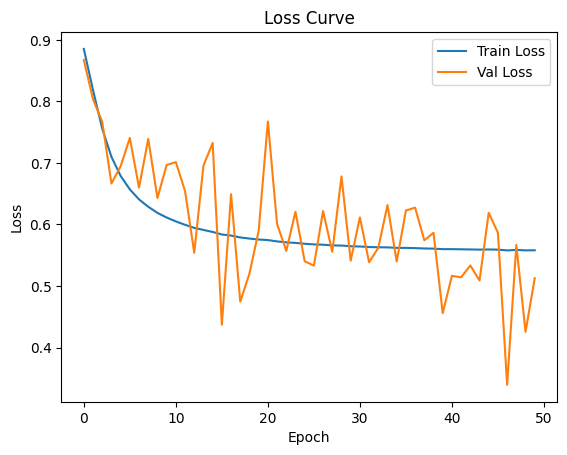

In [ ]:
if len(train_losses) > 1:
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curve')
    plt.legend()
    plt.show()

In [ ]:
print(X.shape)
print(y.shape)

torch.Size([50, 1, 201, 12])
torch.Size([50, 1, 24])


## Caveat
The current network attempts to train how to predict a single frame with temporal context. What really happens is that it take out a frame, with +-25 for context; then predict which chord corresponds to that frame.

For misalignment this is not neccessary, as we would simple load the whole sequence with multiple frames, then align it implicitly and output the whole sequence.

`TODO`: refactor by remove temporal smoothness process.

`IDEAL`: parse L frames `(B,1,L,12)` and predict corresponding sequence `(B,1,L,24)`

Then for testing, we can effectively parse the input sequence, predict then plot it.

## Training Data - Weakly Aligned Dataset

Train the model. Now the targets will be shortened by removing repetition (remove the frame if they are the same as their previous).